In [130]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model, Sequential


os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [131]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_26704\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_26704\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_26704\2312531484.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [132]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [133]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [134]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [135]:
data = data.dropna()

In [136]:
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted', color='red')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()


In [163]:
def custom_train_test(train, test, steps):
    X_train, y_train, X_test, y_test = [], [], [], [] 
    for i in range(steps, len(train)):
        X_train.append(train[i-steps:i])
        y_train.append(train[i])

    for i in range(steps, len(test)):
        X_test.append(test[i-steps:i])
        y_test.append(test[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_test, y_test


n_train = 35064
n_test = int(len(data)-n_train)
window_size = 24

features = ['total_aggregated']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = target_scaler.transform(feature_array)

# Define window size for input data

train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

X_train, y_train, X_test, y_test = custom_train_test(train_data, test_data, window_size)

In [138]:
truth = feature_array[-len(y_test):]

In [139]:
#features = ['total_aggregated']
#total = data[features].values
## Create a DataFrame from the observations
#df = pd.DataFrame(total, columns=['total_aggregated'])
#
## Create 24 lags and store them as new columns in the DataFrame
#for i in range(1, 25):
#    df[f'lag_{i}'] = df['total_aggregated'].shift(i)
#
## Interpolate missing values
#df = df.bfill()
#df
## Define the number of train and test observations
#n_train = 35064
#
## Separate the lags (features) and the observation (target)
#X = df.drop('total_aggregated', axis=1)
#y = df['total_aggregated']
#
## Separate the features into training and test sets
#X_train = X[:n_train]
#X_test = X[n_train:]
#
## Initialize the scaler
#scaler = StandardScaler()
#
## Fit the scaler on the training data and transform it
#X_train_scaled = scaler.fit_transform(X_train)
#
## Use the fitted scaler to transform the test data
#X_test_scaled = scaler.transform(X_test)
#
## Separate the target into training and test sets
#y_train, y_test = y[:n_train], y[n_train:]
#
## Fit the scaler on the training data and transform it
#y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
#
## Use the fitted scaler to transform the test data
#y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))


In [164]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)

In [165]:
# Define the CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
#cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
#cnn.add(Dense(1, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer=optimizer, loss=loss, metrics=metric)

cnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 22, 16)            64        
                                                                 
 conv1d_33 (Conv1D)          (None, 20, 16)            784       
                                                                 
 flatten_19 (Flatten)        (None, 320)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 321       
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


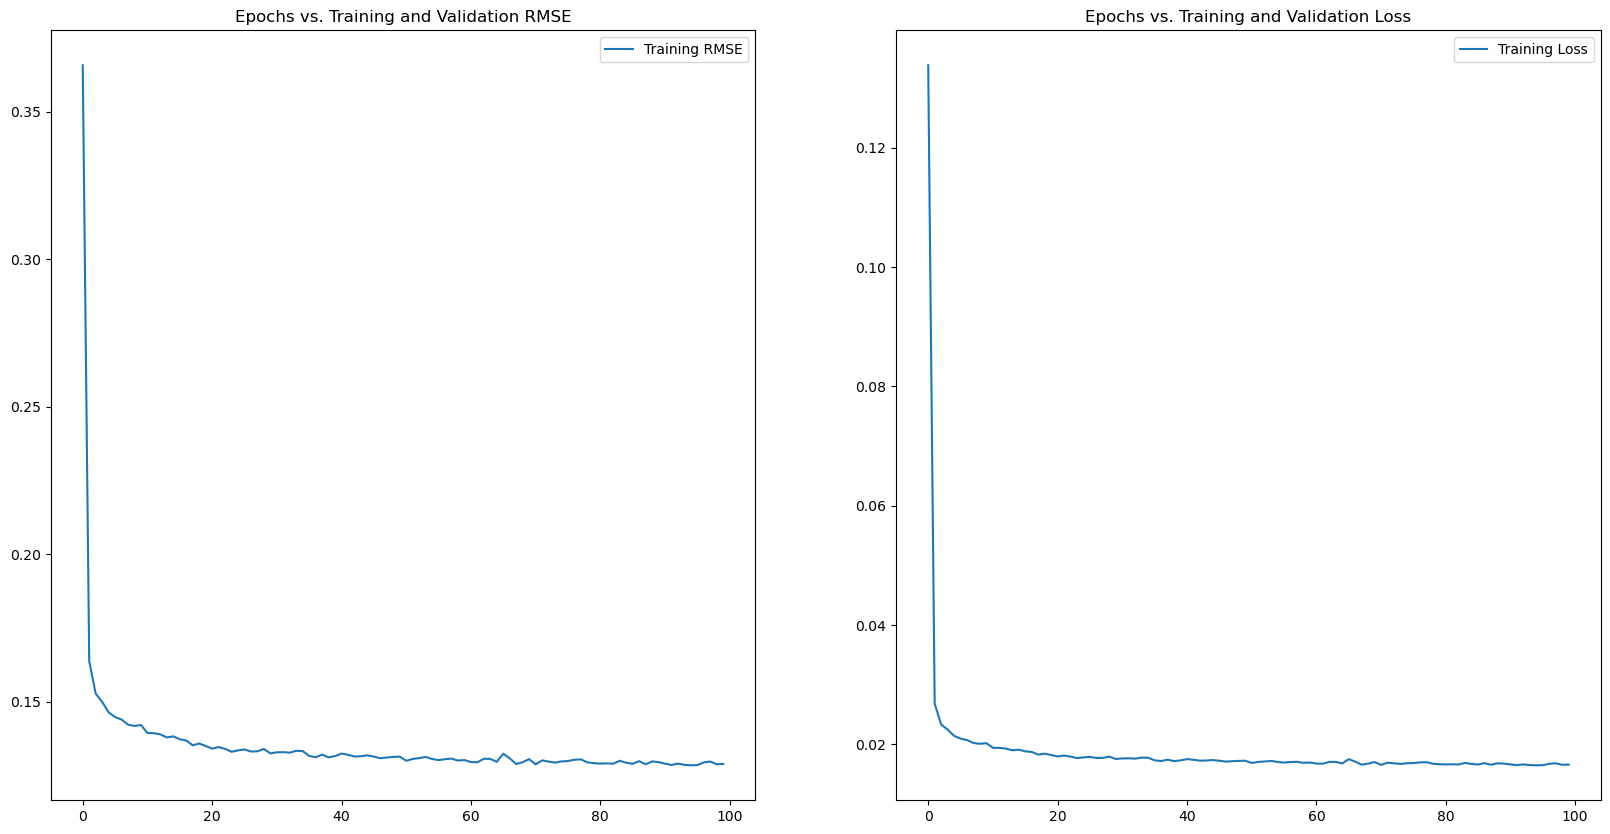

In [166]:
# Fit the model on the training data
history = cnn.fit(X_train, y_train, epochs=100, batch_size=168, verbose=0)
plot_model_rmse_and_loss(history)

In [143]:
# Make predictions on the test data
y_pred = cnn.predict(X_test)

# Inverse transform the scaled test data and predictions
#y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

548/548 [==============================] - 2s 3ms/step


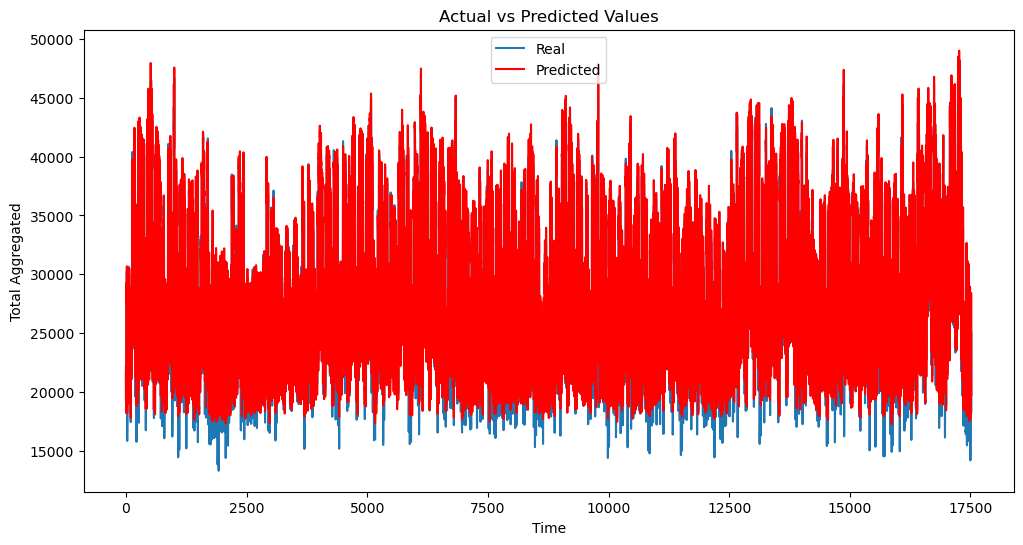

In [144]:
# Plot the actual and predicted values
plot_preds_vs_actual(truth, y_pred_inv)

In [145]:
mse = sqrt(np.mean((truth - y_pred_inv)**2))
print('Mean Squared Error:', mse)

Mean Squared Error: 1539.7968374579148


In [146]:
#energies = ['biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste','wind','total_aggregated', 'hydro_tot', 'gas_tot']

## Forecast With saturday and sunday dummies

In [167]:
def create_timestamps(vector, window_size):
    X, Y = [], []
    for i in range(window_size, len(vector)):
        X.append(vector[i-window_size:i, :])
        Y.append(vector[i, 0])
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [168]:
features = ['total_aggregated', 'saturday', 'sunday']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
#scaled_array = target_scaler.transform(feature_array)

scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

In [169]:
# Define window size for input data
train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

#train_data = feature_array[:n_train]
#test_data = feature_array[len(train_data):]

# Prepare training data
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, :])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare test data
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, :])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [170]:
# Define the CNN model
cnn2 = Sequential()
cnn2.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn2.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
#cnn2.add(MaxPooling1D(pool_size=2))
cnn2.add(Flatten())
cnn2.add(Dense(1, activation='relu'))
cnn2.add(Dense(1))
cnn2.compile(optimizer=optimizer, loss=loss, metrics=metric)

cnn2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 22, 16)            160       
                                                                 
 conv1d_35 (Conv1D)          (None, 20, 16)            784       
                                                                 
 flatten_20 (Flatten)        (None, 320)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 321       
                                                                 
 dense_30 (Dense)            (None, 1)                 2         
                                                                 
Total params: 1,267
Trainable params: 1,267
Non-trainable params: 0
_________________________________________________________________


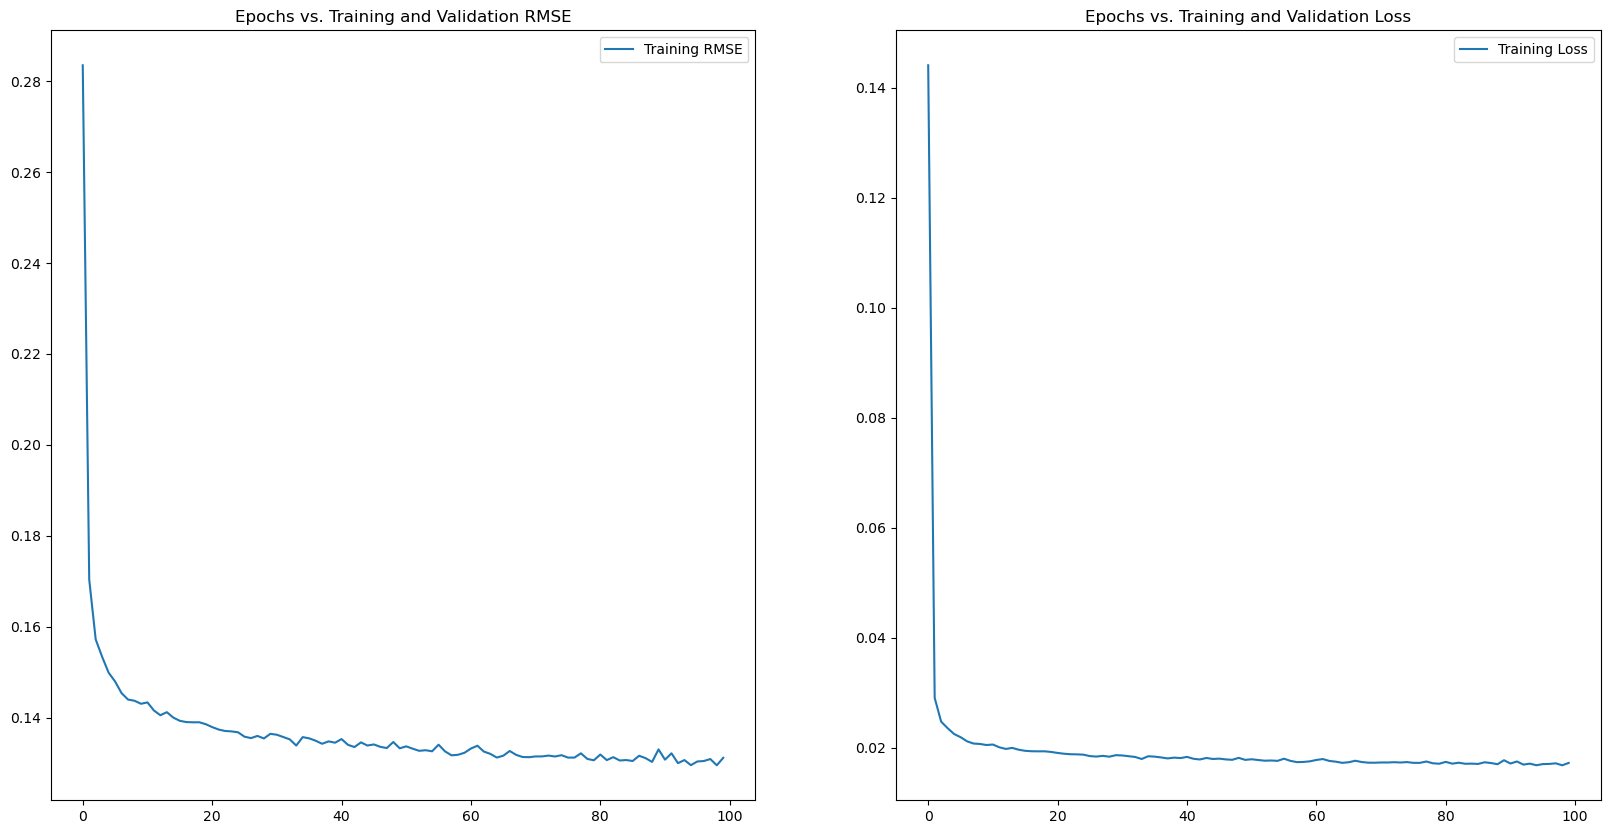

In [171]:
# Fit the model on the training data
history = cnn2.fit(X_train, y_train, epochs=100, batch_size=168, verbose=0)
plot_model_rmse_and_loss(history)

In [152]:
# Make predictions on the test data
y_pred2 = cnn2.predict(X_test)

# Inverse transform the scaled test data and predictions
#y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred2_inv = target_scaler.inverse_transform(y_pred2)

548/548 [==============================] - 2s 4ms/step


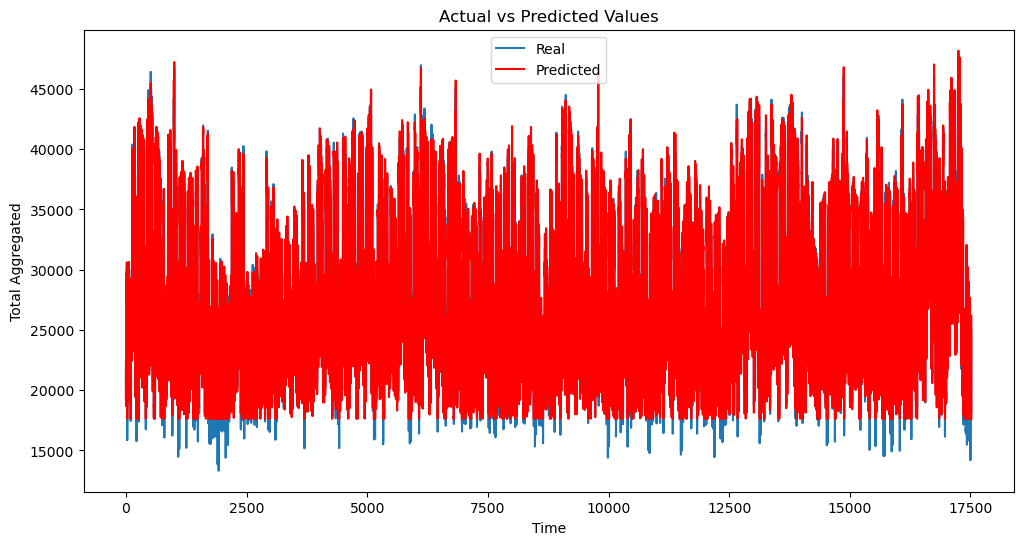

In [153]:
plot_preds_vs_actual(truth, y_pred2_inv)

In [154]:
mse2 = sqrt(np.mean((truth - y_pred2_inv)**2))
print('Mean Squared Error:', mse2)

#mse_inv = sqrt(np.mean((y_pred_inv - y_test_inv)**2))
#print('Mean Squared Error:', mse_inv)

Mean Squared Error: 1157.059064193486


# With business hour dummy

In [172]:
features = ['total_aggregated', 'business hour']
feature_array = data[features].values

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
#scaled_array = target_scaler.transform(feature_array)

scaled_feature = target_scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()
# Define window size for input data
train_data = scaled_array[:n_train]
test_data = scaled_array[len(train_data):]

#train_data = feature_array[:n_train]
#test_data = feature_array[len(train_data):]

# Prepare training data
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, :])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare test data
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, :])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [173]:
# Define the CNN model
cnn3 = Sequential()
cnn3.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn3.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
#cnn3.add(MaxPooling1D(pool_size=2))
cnn3.add(Flatten())
#cnn3.add(Dense(1, activation='relu'))
cnn3.add(Dense(1))
cnn3.compile(optimizer=optimizer, loss=loss, metrics=metric)

cnn3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 22, 16)            112       
                                                                 
 conv1d_37 (Conv1D)          (None, 20, 16)            784       
                                                                 
 flatten_21 (Flatten)        (None, 320)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 321       
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


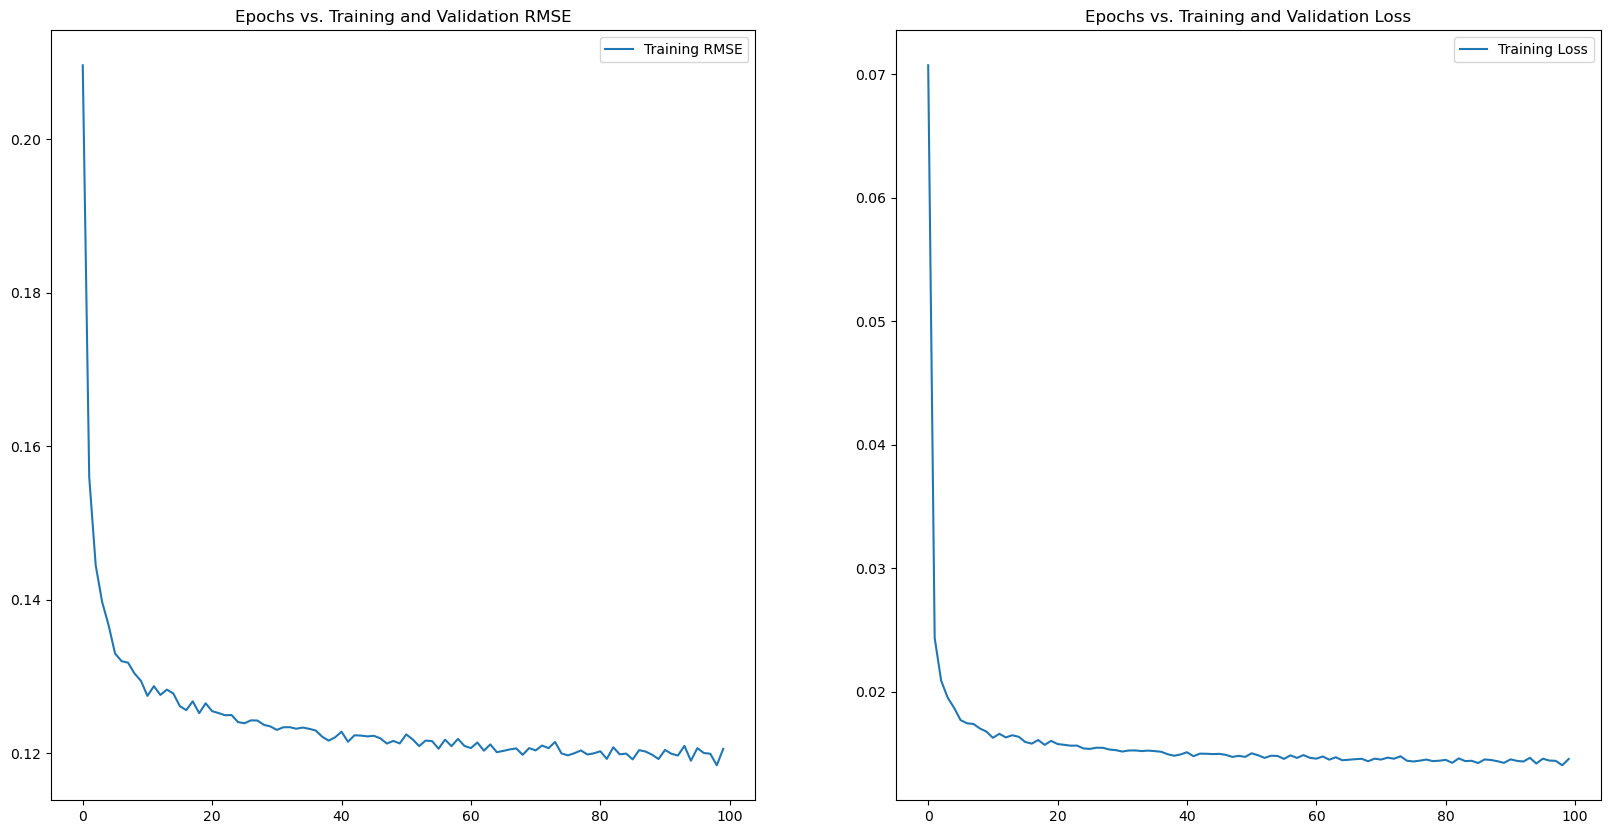

In [174]:
# Fit the model on the training data
history = cnn3.fit(X_train, y_train, epochs=100, batch_size=168, verbose=0)
plot_model_rmse_and_loss(history)

In [158]:
# Make predictions on the test data
y_pred3 = cnn3.predict(X_test)

## Inverse transform the scaled test data and predictions
#y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred3_inv = target_scaler.inverse_transform(y_pred3)


548/548 [==============================] - 2s 3ms/step


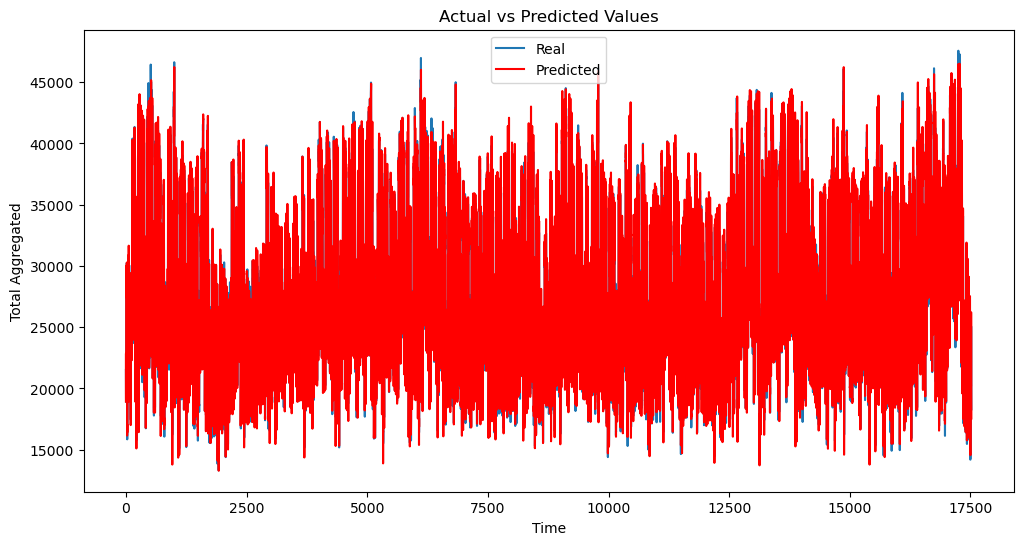

In [159]:
plot_preds_vs_actual(truth, y_pred3_inv)

In [160]:
#mse = sqrt(np.mean((y_pred3 - y_test)**2))
#print('Mean Squared Error:', mse)
#
##mse_inv = sqrt(np.mean((y_pred_inv - y_test_inv)**2))
##print('Mean Squared Error:', mse_inv)

In [161]:
res = pd.DataFrame(y_pred3_inv, columns=['y_pred3'])
res['y_pred'] = y_pred_inv
res['y_pred2'] = y_pred2_inv
res['y_true'] = pd.Series(truth.flatten())

In [162]:
mse1 = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Root Mean Squared Error just TS:', mse1)
mse2 = sqrt(np.mean((res.y_true - res.y_pred2)**2))
print('Root Mean Squared Error WE dummies:', mse2)
mse3 = sqrt(np.mean((res.y_true - res.y_pred3)**2))
print('Root Mean Squared Error BH dummy:', mse3)

Root Mean Squared Error just TS: 1539.7968374578588
Root Mean Squared Error WE dummies: 1157.059064193486
Root Mean Squared Error BH dummy: 1169.405122579917
